# Data Scraping

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

# Define the URL to scrape the news headlines
url = 'https://news.google.com/search?q=new+york+city+crime&hl=en-US&gl=US&ceid=US%3Aen'

# Send a request to get the HTML content
res = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(res.content, 'html.parser')

# Find all the headlines and their dates
headlines = soup.find_all('div', class_='NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')

# Create an empty dataframe to store the data
columns = ['Date', 'Headline']
crime_df = pd.DataFrame(columns=columns)

# Iterate over the headlines and extract the date and headline text
for headline in headlines:
    date = headline.find('time')['datetime']
    text = headline.find('a', class_='DY5T1d').text
    crime_df = crime_df.append({'Date': date, 'Headline': text}, ignore_index=True)


In [ ]:
crime_df.head(5)

,Date,Headline
0,2023-03-25T12:45:21Z,"Man shot dead, another wounded after argument,..."
1,2023-03-28T19:40:39Z,"Noise complaints are on the rise in NYC, and t..."
2,2023-03-28T02:42:10Z,"NYC crime: Man wanted for alleged robbery, sex..."
3,2023-03-27T22:53:07Z,Uptick in car and car part thefts causing conc...
4,2023-03-28T01:11:28Z,Man fatally shot at Astoria Houses in Queens: ...


In [ ]:
import pandas as pd
from nltk.stem import SnowballStemmer

# Create a stemmer object
stemmer = SnowballStemmer('english')

# Define the DataFrame and column to be stemmed
crime_df['Headline']

# Define a function to apply stemming to a single string
def stem_text(text):
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stemmed_words)

# Apply the stemming function to the DataFrame
crime_df['Headline'] = crime_df['Headline'].apply(stem_text)



In [ ]:
crime_df.head(5)

,Date,Headline
0,2023-03-25T12:45:21Z,"man shot dead, anoth wound after argument, pur..."
1,2023-03-28T19:40:39Z,"nois complaint are on the rise in nyc, and the..."
2,2023-03-28T02:42:10Z,"nyc crime: man want for alleg robbery, sexual ..."
3,2023-03-27T22:53:07Z,uptick in car and car part theft caus concern ...
4,2023-03-28T01:11:28Z,man fatal shot at astoria hous in queens: nypd


Total headlines: 82
Headlines with keywords: 44
Headlines without keywords: 38


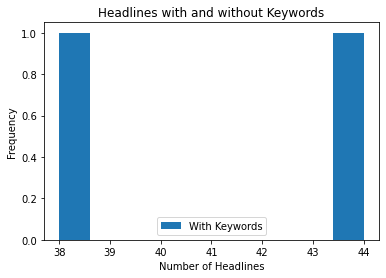

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the news headlines
#news_df = pd.read_csv('crime_data.csv')

# Define the keywords to search for
keywords = ['crime', 'violent', 'accident']

# Initialize the count variables
total_headlines = len(crime_df)
keyword_headlines = 0

# Iterate through the headlines
for headline in crime_df['Headline']:
    # Check if the headline contains any of the keywords
    if any(keyword in headline.lower() for keyword in keywords):
        keyword_headlines += 1

# Print the results
print(f'Total headlines: {total_headlines}')
print(f'Headlines with keywords: {keyword_headlines}')
print(f'Headlines without keywords: {total_headlines - keyword_headlines}')

# Plot a histogram of the results
plt.hist([keyword_headlines, total_headlines - keyword_headlines])
plt.title('Headlines with and without Keywords')
plt.xlabel('Number of Headlines')
plt.ylabel('Frequency')
plt.legend(['With Keywords', 'Without Keywords'])
plt.show()

In [ ]:
import pandas as pd

# Read the CSV file into a Pandas DataFrame
#df = pd.read_csv('crime_data.csv')

# Define a list of spcial characters to check for
special_chars = ['���', '!', '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+', '=', '[', ']', '{', '}', '|', '\\', ';', ':', '\'', '\"', ',', '<', '>', '.', '/', '?']

# Create a function to check if a string contains any of the special characters
def has_special_chars(string):
    for char in special_chars:
        if char in string:
            return True
    return False

# Drop any rows where the statement in the specified column contains special characters between its words
df = crime_df[~crime_df['Headline'].apply(has_special_chars)]

In [ ]:
crime_df.to_csv('crime_data.csv', index=False)

In [ ]:
import spacy

# load the pre-trained NLP model
nlp = spacy.load('en_core_web_sm')

# define a function to extract locations from a statement
def extract_street_address(statement):
    # apply the NLP model to the statement
    doc = nlp(statement)
    
    # initialize empty lists to store city and street names
    cities = []
    streets = []
    
    # loop over each token in the document
    for token in doc:
        # if the token is a proper noun and its text is not "I"
        if token.pos_ == 'PROPN' and token.text != 'I':
            # if the token is labeled as a city in the NER output
            if token.ent_type_ == 'GPE':
                cities.append(token.text)
            # if the token is labeled as a street in the NER output
            elif token.ent_type_ == 'FAC':
                streets.append(token.text)
    
    # return the extracted city and street names as a dictionary
    #return {'cities': cities, 'streets': streets}
    return streets #
    


In [ ]:
import re
import pandas as pd 
from geopy.geocoders import Nominatim
import datetime
import requests

###########################################################################################
data_set = pd.read_csv('Updated_Crimes.csv')
data_scrap = pd.read_csv('crime_data.csv')


# keywords
Murder_keywords = ["Murder", "Kill" , "Shot" ,"shot", "Homicide", "Manslaughter", "Assassination", "Killing", "Slaying", "Butchery", "Execution", 
            "Massacre", "Carnage", "Elimination", "Annihilation", "Taking a life", "Murderous act",
            "Death at the hands of another", "Violent death", "Cold-blooded killing", 
             "Fatal attack", "Premeditated murder", "Unlawful killing", "Culpable homicide",
             "First-degree murder", "Second-degree murder", "Felony murder"]

Kidnap_keywords = ["Robbery", "Burglary", "Theft", "Larceny", "Heist", "Mugging", "Hold-up", "Stick-up", "Raid", 
                   "Plunder", "Rip-off", "Stealing", "Snatching", "Embezzlement", "Pickpocketing", "Purse-snatching", "Armed robbery", 
                   "Bank robbery", "Carjacking", "Smash-and-grab robbery"]

rape_keywords = ["sexual assault", "rape" ,"sexual violence" ,"sexual abuse" ,"sexual misconduct" , "sexual harassment", "molestation"]

Harassment_Keywords = ["Harassment", "Intimidation", "Bullying", "Verbal abuse", "Sexual harassment", 
                       "Discrimination", "Stalking", "Cyberbullying", "Hate speech", "Threatening behavior", "Unwanted advances", 
                       "Catcalling", "Inappropriate behavior", "Coercion", "Blackmail", "Physical harassment", 
                       "Emotional abuse", "Psychological harassment", "Workplace harassment", "Racial harassment"]

Robbery_Snatching_Keywords = ["Snatch","robbe","Snatching" , "Grabbing", "Seizing", "Theft", "Robbery", "Larceny", "Purse-snatching", "Pickpocketing", "Theft by snatching",
                      "Street robbery", "Bag-snatching", "Chain-snatching", "Phone-snatching", "Mugging"]

#Loading the data into the dataframe
#df = pd.DataFrame(columns=columns)

# Example text
location_regex = r'on the\s*(\w+\s*)*|on\s*(\w+\s*)*,'
sentences = data_scrap['Headline']


# Extract the sentences that contain the keywords
#sentences = re.split('\. |\? |\! ', sentence)


for sentence in sentences:
    # Statement Checking Murder  
    for Murder_keyword in Murder_keywords:
      if any(re.search(r'\b{}\b'.format(Murder_keyword), sentence, re.IGNORECASE) for Murder_Keyword in Murder_keywords):  
          if re.search(location_regex, sentence, re.IGNORECASE):
              street_address = extract_street_address(sentence)   
              if street_address in data_set['Park '].values:
                  data_set.loc[data_set['Park '] == street_address, "Murder"] += 5  
              else:
                # Create a dictionary with column names and values
                new_row = {'Park ': street_address, 'Murder': 5, 'Robbery': 0, 'Rape': 0, 'Kidnapping': 0, 'Harassment': 0}
                # Append the dictionary as a new row to the dataset
                data_set = data_set.append(new_row, ignore_index=True) 
          else:
            break
      else:
         break 
       
            
    # Statement Checking Robbery 
    for Robbery_Snatching_Keyword in Robbery_Snatching_Keywords:
      if any(re.search(r'\b{}\b'.format(Robbery_Snatching_Keyword), sentence, re.IGNORECASE) for Robbery_Snatching_Keyword in Robbery_Snatching_Keywords):  
          if re.search(location_regex, sentence, re.IGNORECASE):
              street_address = extract_street_address(sentence)   
              if street_address in data_set['Park '].values:
                  data_set.loc[data_set['Park '] == street_address, "Robbery"] += 2  
              else:
                  # Create a dictionary with column names and values
                  new_row = {'Park ': street_address, 'Murder': 0, 'Robbery': 2, 'Rape': 0, 'Kidnapping': 0, 'Harassment': 0}
                  # Append the dictionary as a new row to the dataset
                  data_set = data_set.append(new_row, ignore_index=True) 
          else:
              break
      else:
          break 
        
    
    # Statement Checking Harassment
    for Harassment_Keyword in Harassment_Keywords:
        if any(re.search(r'\b{}\b'.format(Harassment_Keyword), sentence, re.IGNORECASE) for Harassment_Keyword in Harassment_Keywords):  
            if re.search(location_regex, sentence, re.IGNORECASE):
                street_address = extract_street_address(sentence)   
                if street_address in data_set['Park '].values:
                    data_set.loc[data_set['Park '] == street_address, "Harassment"] += 3  
                else:
                    # Create a dictionary with column names and values
                    new_row = {'Park ': street_address, 'Murder': 0, 'Robbery': 0, 'Rape': 0, 'Kidnapping': 0, 'Harassment': 3}
                    # Append the dictionary as a new row to the dataset
                    data_set = data_set.append(new_row, ignore_index=True) 
            else:
                break
        else:
            break 

  
#Statement Checking Rape  
  
    for rape_Keyword in rape_keywords:
        if any(re.search(r'\b{}\b'.format(rape_Keyword), sentence, re.IGNORECASE) for rape_keyword in rape_keywords):  
            if re.search(location_regex, sentence, re.IGNORECASE):
                street_address = extract_street_address(sentence)   
                if street_address in data_set['Park '].values:
                    data_set.loc[data_set['Park '] == street_address, "Rape"] += 4  
                else:
                    # Create a dictionary with column names and values
                    new_row = {'Park ': street_address, 'Murder': 0, 'Robbery': 0, 'Rape': 4, 'Kidnapping': 0, 'Harassment': 0}
                    # Append the dictionary as a new row to the dataset
                    data_set = data_set.append(new_row, ignore_index=True) 
            else:
                break
        else:
            break      


#Statement Checking Kidnapping 

    for rape_Keyword in rape_keywords:
        if any(re.search(r'\b{}\b'.format(Kidnap_keyword), sentence, re.IGNORECASE) for Kidnap_keyword in Kidnap_keywords):  
            if re.search(location_regex, sentence, re.IGNORECASE):
                street_address = extract_street_address(sentence)   
                if street_address in data_set['Park '].values:
                    data_set.loc[data_set['Park '] == street_address, "Rape"] += 3  
                else:
                    # Create a dictionary with column names and values
                    new_row = {'Park ': street_address, 'Murder': 0, 'Robbery': 0, 'Rape': 0, 'Kidnapping': 3, 'Harassment': 0}
                    # Append the dictionary as a new row to the dataset
                    data_set = data_set.append(new_row, ignore_index=True) 
            else:
                break
        else:
            break   






data_set.to_csv('Updated_Crimes.csv', index=False)

In [ ]:
import pandas as pd
from geopy.geocoders import Nominatim
crime=pd.read_csv('updated_data.csv')
#print(crime.columns)
"""
crime['lat'] = ""
crime['long'] = ""
"""
geolocator = Nominatim(user_agent="myApp")

for i in crime.index:
    try:
        #tries fetch address from geopy
        location = geolocator.geocode(crime['Park '][i])
        
        #append lat/long to column using dataframe location
        crime.loc[i,'Latitude'] = location.latitude
        crime.loc[i,'Longitude'] = location.longitude
  
    except:
        #catches exception for the case where no value is returned
        #appends null value to column
        crime.loc[i,'Latitude'] = ""
        crime.loc[i,'Longitude'] = ""

print(crime.columns)
"""
location = geolocator.geocode(crime["Park"][10])
print(location.latitude, location.longitude)    
#40.74313843618834, -73.73852180697574
"""

In [ ]:
Crimes = pd.read_csv('Updated_Crimes.csv')
Crimes.head(5)

,Unnamed: 0,Park,Longitude,Latitude,Murder,Rape,Robbery,Kidnapping,Harassment,Total Crime,Area,Size(Acres),safe_path
0,0,PELHAM BAY PARK,-73.822154,40.854131,0.0,0.0,2.0,3.0,0.0,5.0,BRONX,2771.747,NaN
1,1,VAN CORTLANDT PARK,-73.886580,40.897075,0.0,0.0,0.0,0.0,0.0,0.0,BRONX,1146.430,NaN
2,3,FRESHKILLS PARK,-74.179968,40.579189,0.0,0.0,0.0,0.0,0.0,0.0,STATEN ISLAND,913.320,NaN
3,4,FLUSHING MEADOWS CORONA PARK,-73.842754,40.740421,0.0,0.0,0.0,0.0,3.0,3.0,QUEENS,897.690,NaN
4,5,MARINE PARK,-73.934197,40.605579,0.0,0.0,0.0,0.0,0.0,0.0,BROOKLYN,798.000,NaN
